# Context aware pulse gate calibration with Reinforcement Learning

This notebook takes advantage of pulse level simulation through Qiskit Dynamics module to perform context aware pulse gate calibration. The main difference with the other notebook that works for both ```DynamicsBackend``` and real backends is that we take advantage of JAX to increase significantly the simulation speed, which turns out to be a limiting factor when dealing with the way ```DynamicsBackend``` is originally designed.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys
module_path = os.path.abspath(os.path.join('/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Qiskit imports
from qiskit import pulse, transpile
from qiskit.transpiler import InstructionDurations
from qiskit.circuit import ParameterVector, QuantumCircuit, QuantumRegister, Gate, CircuitInstruction

from qconfig import QiskitConfig
from quantumenvironment import QuantumEnvironment
from torch.distributions import Normal

import numpy as np
import tqdm
import time
from typing import Union, Optional, List, Sequence
from IPython.display import clear_output
import jax
jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
# import Array and set default backend
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

/Users/arthurstrauss/opt/anaconda3/envs/rl_qoc/lib/python3.9/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [3]:
physical_qubits = [0, 1]
sampling_Paulis = 50
N_shots = 200
n_actions = 4  # Cf number of parameters in custom_schedule function above
abstraction_level = 'pulse'

In [4]:
# Example of target gate
from qiskit.circuit.library.standard_gates import ECRGate, XGate
ECR_tgt = {"gate": ECRGate(), "register": physical_qubits}
target = ECR_tgt
print(target)

{'gate': Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[]), 'register': [0, 1]}


In [5]:
target = {"gate": XGate(), "register": [0]}

## Setting up Quantum Backend

### Simulation backend initialization: Qiskit Dynamics
If you want to run the algorithm over a simulation, one can use Qiskit Dynamics for pulse level simulation of quantum circuits. Below we set the ground for declaring a ```DynamicsBackend```.

This can be done in two ways: 

1. Declare a ```DynamicsBackend``` from a ```FakeBackend``` or ```IBMBackend``` instance and use the ```from_backend()``` method to retrieve the Hamiltonian description of such backend.
2. Alternatively, you can define your own custom Hamiltonian/Linblad that should be used to simulate the multiqubit system of interest, and feed it to a ```Solver``` instance which can be used to declare the ```DynamicsBackend```.
For more information you can check Qiskit Dynamics documentation (https://qiskit.org/documentation/dynamics/apidocs/backend.html)


In [6]:
from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta, FakeJakartaV2
from helper_functions import get_control_channel_map
from qiskit_dynamics import DynamicsBackend, Solver
from helper_functions import get_solver_and_freq_from_backend

fake_backend = FakeJakarta()
fake_backend_v2 = FakeJakartaV2()
control_channel_map = get_control_channel_map(fake_backend, physical_qubits)
dt = fake_backend_v2.target.dt
print("Coupling Map: ",list(fake_backend_v2.coupling_map.get_edges()))

Coupling Map:  [(5, 4), (4, 5), (1, 3), (3, 1), (6, 5), (5, 6), (3, 5), (5, 3), (2, 1), (1, 2), (0, 1), (1, 0)]


In [7]:
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax":dt}
dynamics_options = {'seed_simulator': None, #"configuration": fake_backend.configuration(),
                    'control_channel_map': control_channel_map, 
                    "solver_options": solver_options
                    }
qubit_properties = fake_backend_v2.qubit_properties(physical_qubits)

In [8]:
# Using the from_backend method
dynamics_backend = DynamicsBackend.from_backend(fake_backend, subsystem_list=physical_qubits, **dynamics_options)
dynamics_backend.target.qubit_properties = qubit_properties

I0000 00:00:1697712676.795118       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [9]:
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver, Signal
from pulse_jax_backend import JaxSolver

dt, v0, r0 = 1/4.5e9, 4.86e9, 0.22e9

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')
s_p = 0.5 * (X + 1j * Y)

solver_1q = JaxSolver(
    static_hamiltonian=.5 * 2 * np.pi * v0 * Z,
    hamiltonian_operators=[2 * np.pi * r0 * X],
    rotating_frame = .5 * 2 * np.pi * v0 * Z,
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": v0},
    dt=dt,
    evaluation_mode="dense", jittable_func = lambda x: x**2
    
)


In [10]:
dim = 2

v0, v1 = 4.86e9, 4.97e9
anharm0, anharm1 = -0.32e9, -0.32e9
r0, r1 = 0.22e9, 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0, N1 = np.kron(ident, N), np.kron(N, ident)
a0, a1 = np.kron(ident, a), np.kron(a, ident) 
a0dag, a1dag = np.kron(ident, adag), np.kron(adag, ident)

static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

# build solver
dt = 1/4.5e9

solver_2q = JaxSolver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1, drive_op1, drive_op0],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1", "u2", "u3"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0, "u2":v0, "u3": v1},
    dt=dt,
    evaluation_mode="dense", jittable_func = lambda x: x**2
)
# Consistent solver option to use throughout notebook


In [11]:
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, 'hmax':dt}
solver = solver_2q
custom_backend = DynamicsBackend(
    solver=solver,
    #target = fake_backend_v2.target,
    subsystem_dims=[dim, dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)
backend_target = custom_backend.target
channel_freq = None
calibration_files = None
do_calibrations = True
# qubit properties

In [12]:
print(custom_backend.target)

Target
Number of qubits: 2
Instructions:
	measure
		(0,):
			With pulse schedule calibration
		(1,):
			With pulse schedule calibration



## Select backend

In [13]:
# Choose backend among the set defined above
backend = custom_backend

print('Selected Backend: ',backend)
if isinstance(backend, DynamicsBackend):
    print("Subsystem dims: ", backend.options.subsystem_dims)
print('Backend options', backend.options)

Selected Backend:  <qiskit_dynamics.backend.dynamics_backend.DynamicsBackend object at 0x7ff26a26fac0>
Subsystem dims:  [2, 2]
Backend options Options(shots=1024, solver=<pulse_jax_backend.JaxSolver object at 0x7ff26a081220>, solver_options={'method': 'jax_odeint', 'atol': 1e-06, 'rtol': 1e-08, 'hmax': 2.2222222222222221e-10}, subsystem_dims=[2, 2], meas_map=[[0], [1]], control_channel_map=None, normalize_states=True, initial_state='ground_state', meas_level=<MeasLevel.CLASSIFIED: 2>, meas_return=<MeasReturnType.AVERAGE: 'avg'>, iq_centers=None, iq_width=0.2, max_outcome_level=1, memory=True, seed_simulator=None, experiment_result_function=<function default_experiment_result_function at 0x7ff27c60b1f0>, configuration=None, defaults=None)


In [14]:
# Wrap all info in one QiskitConfig
# Qiskit_setup = QiskitConfig(parametrized_circuit=apply_parametrized_circuit, backend=backend)
Qiskit_setup = QiskitConfig(backend=backend)
Qiskit_setup

QiskitConfig(parametrized_circuit=None, backend=<qiskit_dynamics.backend.dynamics_backend.DynamicsBackend object at 0x7ff26a26fac0>, estimator_options=None, solver=None, channel_freq=None, do_calibrations=True, calibration_files=None)

## Declare QuantumEnvironment object
Running the box below declares the QuantumEnvironment instance.

If selected backend is a ```DynamicsBackend```, this declaration launches a series of single qubit gate calibrations (to calibrate X and SX gate). The reason for this is that the Estimator primitive, which enables the computation of Pauli expectation values, requires calibrated single qubit gates for doing Pauli basis rotations (SX and RZ, to perform Hadamard and S gates).

In [15]:
%%time
q_env = QuantumEnvironment(target=target, abstraction_level=abstraction_level,
                           Qiskit_config=Qiskit_setup,
                           sampling_Pauli_space=sampling_Paulis, n_shots=N_shots, c_factor=0.5)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
{(0, 1): 0, (1, 0): 1}
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'x', 'z', 't', 'h', 'reset', 'tdg', 'id', 'sdg', 'sx', 's', 'measure', 'rz'}
  q1: {'x', 'z', 't', 'h', 'reset', 'tdg', 'id', 'sdg', 'sx', 's', 'measure', 'rz'}
Multi qubit instructions:
  (0, 1): {'cr45p', 'ecr', 'cr45m'}
  (1, 0): {'cr45p', 'ecr', 'cr45m'}
)>
CPU times: user 1min 20s, sys: 2.76 s, total: 1min 23s
Wall time: 1min 33s


In [ ]:
print(q_env)

In [ ]:
from qiskit.primitives import BackendEstimator
isinstance(q_env.estimator, BackendEstimator)

In [ ]:
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, gate_map, plot_gate_map
from qiskit.visualization.pulse_v2 import IQXDebugging
plot_gate_map(backend)

In [ ]:
from qiskit.quantum_info import Statevector
y0 = Array(Statevector(np.array([1.0, 0.0])))
dt = 2.222e-10
rtol = 1e-5
atol = 1e-3

h_sched = backend.target.get_calibration("h", (0,))
x_sched = backend.target.get_calibration("x", (0,))
meas_sched = backend.target.get_calibration("measure", (0,))
# build a pulse schedule
with pulse.build(default_alignment="sequential") as schedule:
    pulse.call(x_sched)
    #pulse.call(h_sched)
    #pulse.shift_phase(np.pi, pulse.DriveChannel(0))
    #pulse.call(h_sched)
    
t_linspace = np.linspace(0.0, schedule.duration, 21)
def get_sched(param_values, observables, y0, options):
    sched = my_sched_function(params) # Load parameter
    x_sched = backend.target.get_calibration("x", (0,))
    h_sched = backend.target.get_calibration("h", (0,))
    meas_sched = backend.target.get_calibration("measure", (0,))
    # build a pulse schedule
    with pulse.build(default_alignment="sequential") as schedule:
        pulse.call(x_sched)
        #pulse.shift_phase(phase, pulse.DriveChannel(0))
        #pulse.call(h_sched)
        #pulse.call(meas_sched)
    results = solver.solve(t_span=[t_linspace[0], t_linspace[-1]],
        y0=y0,
        signals=schedule,
        t_eval=t_linspace,
        method='jax_odeint',
        atol=atol,
        rtol=rtol
    )
    
    return results.y


In [ ]:
def from_qc(qc):
    schedule(qc)
    def my_sched_function(params)

In [ ]:
import jax.numpy as jnp
from jax import block_until_ready, vmap
from qiskit_dynamics.array import wrap
jit = wrap(jax.jit, decorator=True)
qd_vmap = wrap(vmap, decorator=True)

sched_fast = jit(get_sched)

In [ ]:
x_sched = backend.target.get_calibration("x", (0,))
h_sched = backend.target.get_calibration("h", (0,))
meas_sched = backend.target.get_calibration("measure", (0,))
# build a pulse schedule
with pulse.build(default_alignment="sequential") as schedule:
    pulse.call(x_sched)
    #pulse.shift_phase(phase, pulse.DriveChannel(0))
    #pulse.call(h_sched)
    #pulse.call(meas_sched)
results = backend.options.solver.solve(t_span=[t_linspace[0], t_linspace[-1]],
    y0=Statevector.from_label("0"),
    signals=schedule,
    t_eval = t_linspace,                                   
    method='jax_odeint',
    atol=atol,
    rtol=rtol
)


In [ ]:
results

In [ ]:
qc = QuantumCircuit(1)
qc.x(0)
qc.measure_all()
job = backend.run(qc)
result = job.result()
result

# Definition of Circuit context

Now that we have established our ```QuantumEnvironment```, we will now focus on the main research point of this paper, which is to calibrate the target gate based on its location within a specific circuit context. As we will use PyTorch to build the interface between our agent and our environment, we will wrap up our original environment within a ```TorchQuantumEnvironment``` object, which will build a suitable environment for dynamical and contextual gate calibration. But first, we define the quantum circuit in which our target operation will appear.

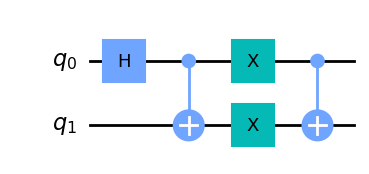

In [16]:
target_circuit = QuantumCircuit(2)
target_circuit.h(0)
target_circuit.cx(0,1)
target_circuit.x([0,1])
target_circuit.cx(0,1)
target_circuit.draw("mpl")

To be able to see where our ECR gate shall appear in the circuit, we have to transpile this logical circuit to the backend. To ease the visualization, we add small functions to see the circuit only on relevant physical qubits.

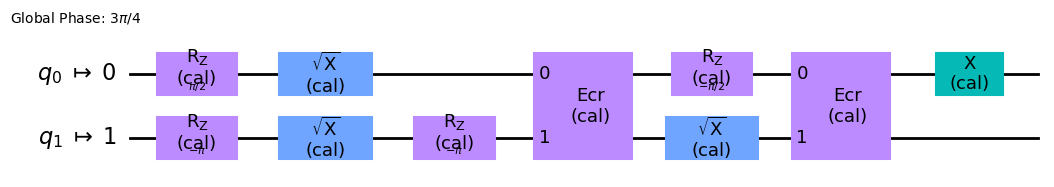

In [17]:
from helper_functions import remove_unused_wires
transpiled_circ = transpile(target_circuit, backend, 
                              initial_layout=physical_qubits,
                              basis_gates=["sx","rz","ecr","x"], 
                              optimization_level=1)
remove_unused_wires(transpiled_circ).draw("mpl")

2.2222222222222221e-10


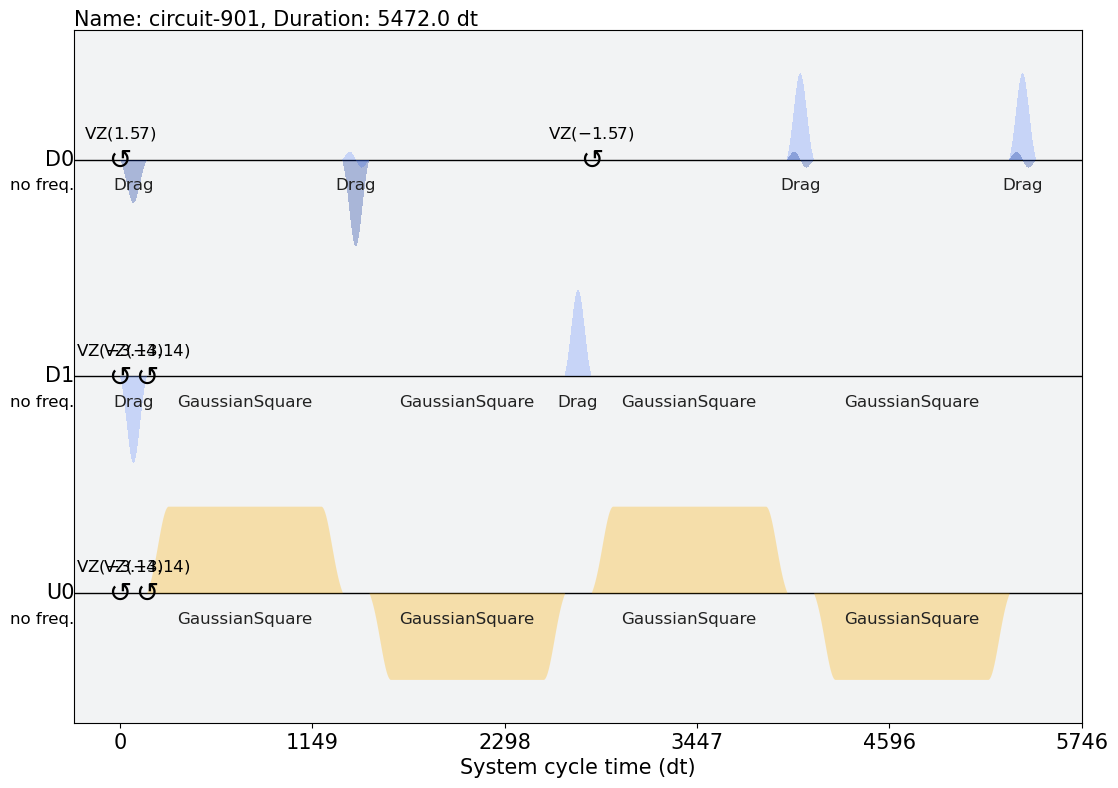

In [18]:
from qiskit import schedule
print(backend.dt)
schedule(transpiled_circ, backend).draw()

# Definition of TorchQuantumEnvironment

To define the ```TorchQuantumEnvironment``` wrapper, we follow the Gym like definition, where we provide the structure of the observation and action spaces.

The class takes the following inputs:
- ```q_env: QuantumEnvironment```: the baseline object where the information about the backend and the target gate is
- ```circuit_context: QuantumCircuit```: The circuit in which the previously defined target operation is applied. Note that the class will automatically look for all instances of the gate within the circuit and build dedicated subcircuits (truncations) enabling the successive calibration of each gate instance. To be noted here: the gate calibration focuses only on the target qubits defined in the ```QuantumEnvironment```. In Qiskit, we typically look for the ```CircuitInstruction``` object composed of a ```Gate``` object and a set of target qubits on which the gate is applied (both defined in target).
- ```action_space```/```observation_space```: Spaces defining the range and shapes of possible actions/observations.
For now, the observation space is fixed to a set of two integers:
    - the first one indicates which random input state was selected at the beginning of the episode, so that the network have an extra information on the randomness source coming from the reward.
    - the second one indicates which instance of the gate it will calibrate. In the real-time use case, we would like the agent to generate on the fly random actions that will be applied directly for the next gate within the circuit execution. With Qiskit Runtime however, we are not able to generate those actions on the fly and will therefore load all actions associated to each instance of the gate prior to execution.


Moreover, we apply for now a sequential training loop, meaning that we will force the agent to focus on the calibration of the first gate (truncating the circuit just behind its execution) before starting to calibrate the second one (and so forth). The number of iterations per gate instance must be provided with the number ```training_steps_per_gate```.

Since we want to run a contextual gate calibration, we need to know exactly how the circuit will be transpiled on the backend. There is therefore an internal transpilation (without any optimization) that enables the retrieval of all timings of the logical gates indicated above. We also account for the local context happening on nearest neighbor qubits on the chip.

Moreover, as we run this sequential gate calibration for each instance of the target gate within the circuit, one can check the different circuit truncations the agent will go over.

Important note: The target type of the calibration must be a quantum Gate instance (it will not work if target is a quantum state).

In [19]:
%%time
# Circuit context
from torch_contextual_gate_calibration.torch_quantum_environment import TorchQuantumEnvironment
from gymnasium.spaces import Box, Space

seed = 10
training_steps_per_gate = 2000
benchmark_cycle = 100
# tgt_instruction_counts = target_circuit.data.count(CircuitInstruction(target_gate, tgt_qubits))
tgt_instruction_counts = 2  # Number of times target Instruction is applied in Circuit
batchsize = 200  # Batch size (iterate over a bunch of actions per policy to estimate expected return) default 100
n_actions = 4 # Choose how many control parameters in pulse/circuit parametrization
min_bound_actions =  - 0.1
max_bound_actions =  0.1
scale_factor = 0.1
observation_space = Box(low=np.array([0, 0]), high=np.array([1, tgt_instruction_counts]), shape=(2,),
                        seed=seed)
action_space = Box(low=min_bound_actions, high=max_bound_actions, shape=(n_actions,), seed=seed)

torch_env = TorchQuantumEnvironment(q_env, target_circuit, action_space,
                                    observation_space, batch_size=batchsize,
                                    training_steps_per_gate=training_steps_per_gate,
                                    benchmark_cycle = benchmark_cycle,
                                    intermediate_rewards=False,
                                    seed=None,)


CPU times: user 210 ms, sys: 99 ms, total: 309 ms
Wall time: 428 ms


/Users/arthurstrauss/opt/anaconda3/envs/rl_qoc/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


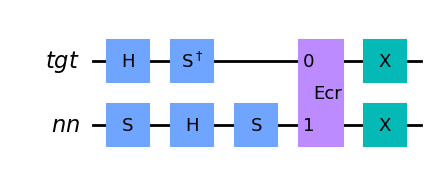

In [20]:
torch_env.circuit_truncations[0].draw("mpl")

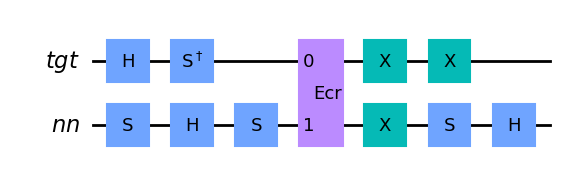

In [21]:
torch_env.circuit_truncations[1].draw("mpl")

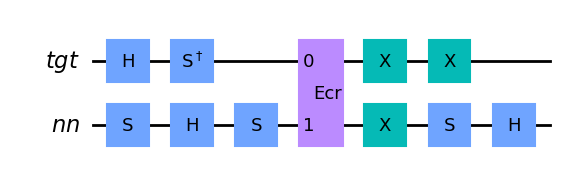

In [22]:
torch_env.baseline_truncations[1].draw("mpl")

In [ ]:
torch_env.estimator.options

In [ ]:
backend.set_options(rep_delay=0.0001)
print(backend.options)

# Definition of the Agent

In [ ]:
import torch
import torch.nn as nn

from agent import ActorNetwork, CriticNetwork, Agent
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
hidden_units = [64, 64]
activation_functions = [nn.Tanh(), nn.Tanh(), nn.Tanh()]
include_critic = False
chkpt_dir = 'tmp/ppo'
chkpt_dir_critic = 'tmp/critic_ppo'

actor_net = ActorNetwork(observation_space, hidden_units, n_actions, activation_functions, include_critic, chkpt_dir).to(device)
critic_net = CriticNetwork(observation_space, hidden_units, activation_functions, chkpt_dir_critic).to(device)
agent = Agent(actor_net, critic_net=critic_net).to(device)

## Hyperparameters for training

In [ ]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
run_name = "test"
writer = SummaryWriter(f"runs/{run_name}")
# writer.add_text(
#     "hyperparameters",
#     "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
# )
# Hyperparameters for the agent
n_epochs = 10  # Number of epochs : default 1500
num_updates = 700
lr_actor = 0.001  # Learning rate for policy update step
lr_critic = 0.001  # Learning rate for critic (value function) update step

epsilon = 0.2  # Parameter for clipping value (PPO)
critic_loss_coeff = 0.5
optimizer = optim.Adam(agent.parameters(), lr=lr_actor, eps=1e-5)
actor_optimizer = optim.Adam(actor_net.parameters(), lr=lr_actor, eps=1e-5)
critic_optimizer = optim.Adam(critic_net.parameters(), lr=lr_critic, eps=1e-5)
minibatch_size = 40
gamma = 1.
gae_lambda = 0.95

# Clipping
clip_vloss = True
grad_clip = 0.5
clip_coef = 0.5
normalize_advantage = False

# other coefficients
ent_coef = 0.

# Training
## Storage setup

In [ ]:
global_step = 0
torch_env.clear_history()
obs = torch.zeros((tgt_instruction_counts, batchsize) + torch_env.observation_space.shape).to(device)
actions = torch.zeros((tgt_instruction_counts, batchsize) + torch_env.action_space.shape).to(device)
logprobs = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
rewards = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
dones = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
values = torch.zeros((tgt_instruction_counts, batchsize)).to(device)

train_obs = torch.zeros((batchsize,) + torch_env.observation_space.shape, requires_grad=True).to(device)
visualization_steps = 10

## Main loop

In [ ]:
for update in tqdm.tqdm(range(1, num_updates + 1)):
    next_obs, _ = torch_env.reset(seed=seed)
    num_steps = torch_env.episode_length(global_step)
    next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
    next_done = torch.zeros(batchsize).to(device)

    # print("episode length:", num_steps)

    for step in range(num_steps):
        global_step += 1
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            mean_action, std_action, critic_value = agent(next_obs)
            mean_action*=scale_factor
            probs = Normal(mean_action, std_action)
            action = torch.clip(probs.sample(), torch.Tensor(np.array(min_bound_actions)), torch.Tensor(np.array(max_bound_actions)))
            logprob = probs.log_prob(action).sum(1)
            values[step] = critic_value.flatten()

        actions[step] = action
        logprobs[step] = logprob
        # next_obs, reward, terminated, truncated, infos = torch_env.step(action.cpu().numpy())
        next_obs, reward, terminated, truncated, infos = torch_env.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device)
        next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
        next_done = torch.Tensor(np.array([int(done)] * batchsize)).to(device)
        # Only print when at least 1 env is done

        # print(f"global_step={global_step}, episodic_return={np.mean(reward)}")
        writer.add_scalar("charts/episodic_return", np.mean(reward), global_step)
        writer.add_scalar("charts/episodic_length", num_steps, global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + torch_env.observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + torch_env.action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batchsize)
    clipfracs = []
    for epoch in range(n_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batchsize, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]
            new_mean, new_sigma, new_value = agent(b_obs[mb_inds])
            new_dist = Normal(new_mean, new_sigma)
            new_logprob, entropy = new_dist.log_prob(b_actions[mb_inds]).sum(1), new_dist.entropy().sum(1)
            logratio = new_logprob - b_logprobs[mb_inds] + torch.log(torch.Tensor([1e-6]))
            ratio = logratio.exp()
            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > epsilon).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if normalize_advantage:  # Normalize advantage
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = new_value.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * critic_loss_coeff

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), grad_clip)
            optimizer.step()

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
    print("mean", mean_action[0])
    print("sigma", std_action[0])
    print("Average return:", np.mean(torch_env.reward_history, axis=1)[-1])
    # print(np.mean(torch_env.reward_history, axis =1)[-1])
    #print("Circuit fidelity:", torch_env.circuit_fidelity_history[-1])
    #print("Avg gate fidelity:", torch_env.avg_fidelity_history[-1])   
    print(torch_env._get_info())
    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/avg_return", np.mean(torch_env.reward_history, axis=1)[-1], global_step)
    #for i in range(num_steps):
     #   writer.add_scalar(f"losses/avg_gate_{i}_fidelity", torch_env.avg_fidelity_history[-1][i], global_step)
    #writer.add_scalar("losses/circuit_fidelity", torch_env.circuit_fidelity_history[-1], global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    if global_step%visualization_steps == 0:
        clear_output(wait=True) # for animation

torch_env.close()
writer.close()


In [ ]:
torch_env.close()
writer.close()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(torch_env.circuit_fidelity_history)

In [ ]:
plt.plot(torch_env.avg_fidelity_history)

In [ ]:
plt.plot(np.mean(torch_env.reward_history, axis=1))

What is below is not relevant to this notebook

In [ ]:
from qiskit.quantum_info import Operator, average_gate_fidelity
from qiskit.circuit.library.standard_gates import CXGate
my_qc = QuantumCircuit(2, name="custom_cx")
optimal_params = [0., 0., 0.5, 0.5, -0.5, 0.5, -0.5]
params = [-0.0062,  0.2190,  0.9921,  0.9924, -0.9921,  0.9910, -0.9907]
my_qc.u(np.pi * params[0], np.pi * params[1], np.pi * params[2], 0)
my_qc.u(np.pi * params[3], np.pi * params[4], np.pi * params[5], 1)
my_qc.rzx(np.pi * params[6], 0, 1)
average_gate_fidelity(Operator(my_qc), Operator(CXGate()))

In [ ]:
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakePerth
from qiskit_aer import AerSimulator
from qiskit_experiments.library import ProcessTomography
from qiskit_experiments.framework import BatchExperiment

backend = AerSimulator.from_backend(FakePerth())
qc = QuantumCircuit(1)
qc.x(0)

result = BatchExperiment([ProcessTomography(qc), ProcessTomography(qc)], 
                         backend=backend, flatten_results=True).run().block_for_results()
print(result.analysis_results("process_fidelity"))

In [ ]:
result.analysis_results("process_fidelity")[0].value

In [ ]:
result.analysis_results("process_fidelity")[1].value